In [799]:
import scraper_utils as su
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV,RidgeCV
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import pickle
import seaborn as sns
sns.set_theme()
sns.set_context('talk')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data in

Load in from csv, add columns for other possible objective functions, filter out old games, then split into training and test data.

In [920]:
df = pd.read_csv('data/games_allcats.csv', index_col = 'Name')
df.rename(columns={'average':'avg_rating'}, inplace = True)
df['log_owned'] = np.log(df['numowned'])
df['log_plays'] = np.log(df['numplays'])
df['avg_rating^2'] = df['avg_rating']**2
df['log_rating'] = np.log(df['avg_rating'])
df['sqrt_minplaytime'] = np.sqrt(df['minplaytime'])
df['sqrt_maxplaytime'] = np.sqrt(df['maxplaytime'])
df['sqrt_price'] = np.sqrt(df['median_price'])
df['age'] = 2021-df['yearpublished']
df['yearly_plays']=df['numplays']/df['age']

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6400 entries, Gloomhaven to Santa Maria Infante: On the Road to Rome 1944
Columns: 107 entries, id to yearly_plays
dtypes: float64(24), int64(83)
memory usage: 5.3+ MB


In [921]:
df.fillna(0,inplace=True)

In [922]:
df=df[df['num_listings']>0]
df=df[df['yearpublished']>=2010]
df=df[df['yearpublished']<=2019]
df=df[df['minage']>0]

In [923]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2607 entries, Gloomhaven to Let's Take a Hike
Columns: 107 entries, id to yearly_plays
dtypes: float64(24), int64(83)
memory usage: 2.1+ MB


In [924]:
train_df, test_df = train_test_split(df, test_size=.2)

In [19]:
with open("category_dict.pkl", 'rb') as picklefile: 
    category_dict = pickle.load(picklefile)
    

## Define sets of columns 

In [562]:
#Game properties, ie things that the game maker can control
game_properties = ['avgweight', 'minplayers', 'maxplayers',
                   'minplaytime', 'maxplaytime', 'minage', 'median_price']
#game_properties = ['avgweight', 'minplayers', 'maxplayers',
#                   'minplaytime', 'minage', 'median_price']


game_properties_sqrt = ['avgweight','minplayers','maxplayers', 'sqrt_minplaytime','sqrt_maxplaytime', 'minage', 'sqrt_price']
#Game properties, no price
game_properties_np = ['avgweight', 'minplayers', 'maxplayers',
                     'minplaytime', 'maxplaytime', 'minage']

#Types
type_cols = ['customizable', 'family', 'strategy', 'thematic']

In [563]:
selected_categories = top10_cats + ['Adventure', 'Party Game', 'Miniatures', 'City Building',
                                    'Exploration','Bluffing','Animals','Fighting']

In [564]:
#Lists of top 10/20/30 categories
top10_cats = list(category_dict.values())[:10]
top20_cats = list(category_dict.values())[:20]
top30_cats = list(category_dict.values())[:30]

#Combined numeric, type, and category columns - what mostly gets used for xcols
x_cols_10 = game_properties + type_cols + top10_cats
x_cols_20 = game_properties + type_cols + top20_cats
x_cols_30 = game_properties + type_cols + top30_cats
x_cols    = game_properties + type_cols + selected_categories
x_cols_np = game_properties + type_cols + selected_categories

x_cols_sqrt = game_properties + type_cols + selected_categories

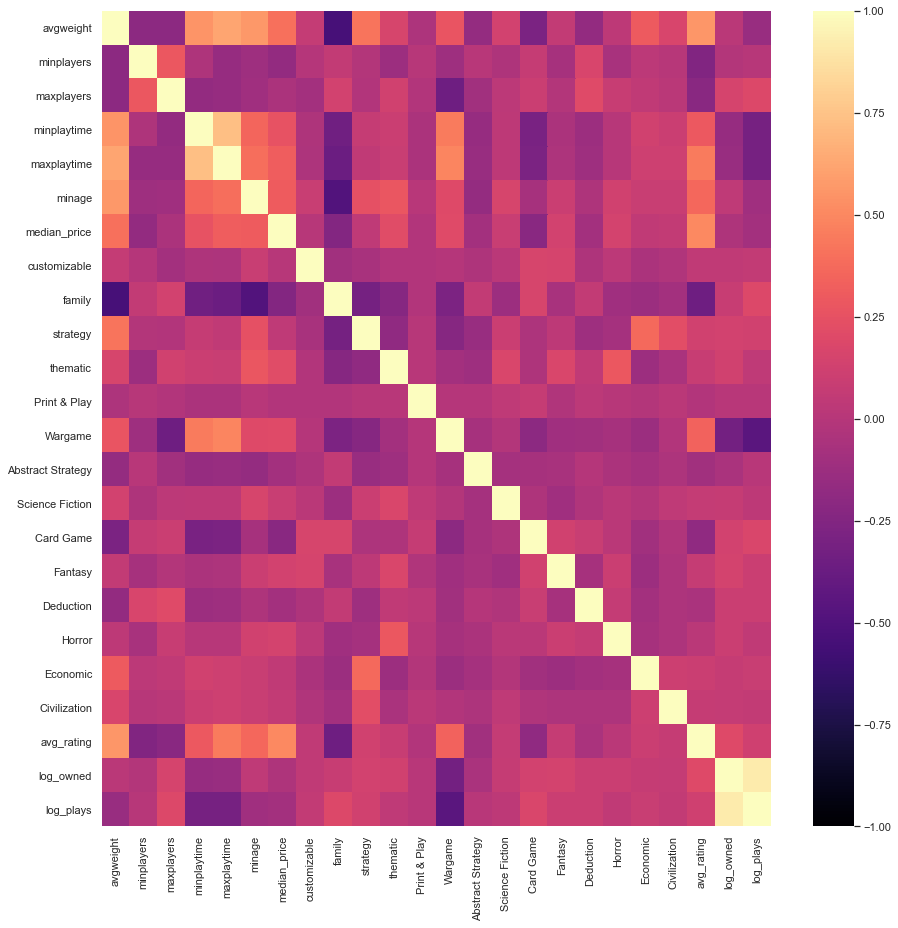

In [565]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df[x_cols_10 + ['avg_rating', 'log_owned', 'log_plays']].corr(), cmap="magma", vmin=-1, vmax=1, ax=ax);

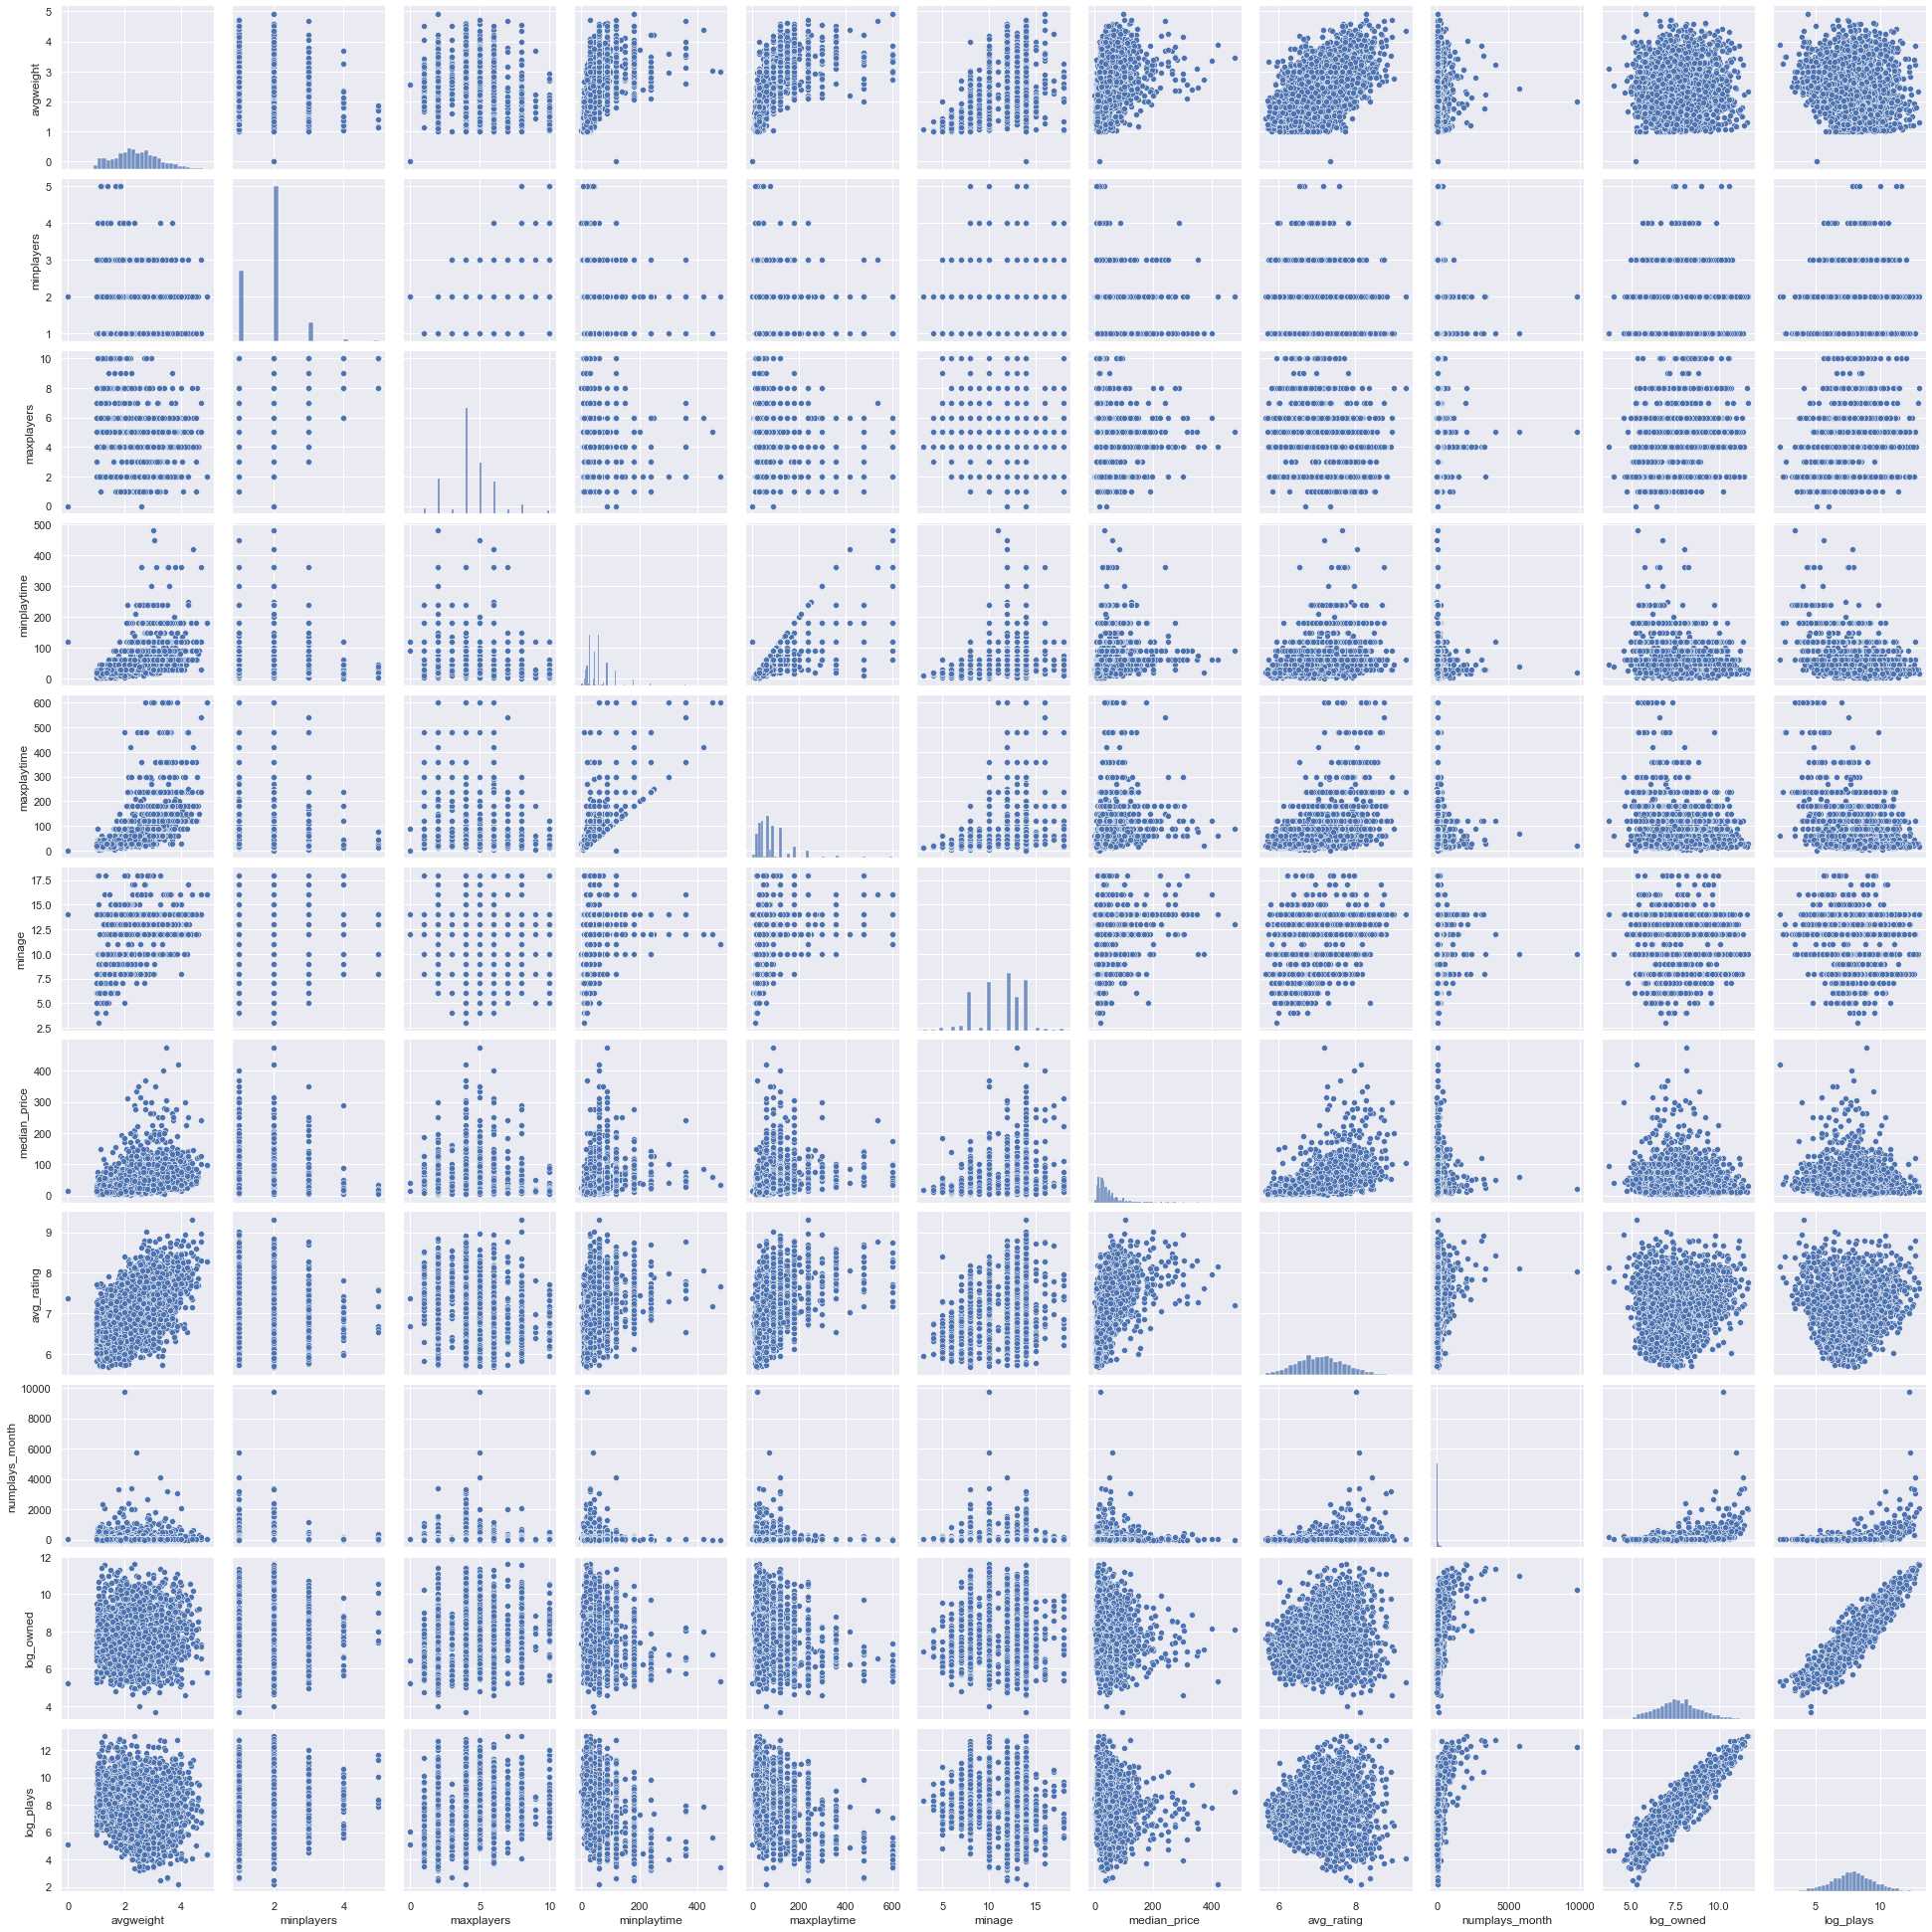

In [672]:
sns.pairplot(df[game_properties + ['avg_rating', 'numplays_month', 'log_owned', 'log_plays']])

## Functions for quickly testing models

In [494]:
def train_test_error(df, xcols, ycol, fitter, fit_params = {}, scale = False, show_results = True, xcols_name = ''):
    """
    Takes in df, names of columns to use as x and y, splits into train and test (validation) sets. Finds train and
    test error, to look for over/underfitting
    """
    X = df[xcols]
    y = df[ycol]
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)
    if scale:
        scaler = StandardScaler()
        X=scaler.fit_transform(X)
    fitter.set_params(**fit_params)
    fitter.fit(X_train, y_train)
    
    #y_train_pred = fitter.predict(X_train)
    #y_test_pred = fitter.predict(X_test)
    
    train_r2 = fitter.score(X_train, y_train)
    test_r2 = fitter.score(X_test, y_test)
    if show_results:    
        print('Objective:', ycol)
        print(f'Features: ', xcols_name)
        print('Train r2:', round(train_r2,3))
        print('Test r2:', round(test_r2,3))
        print()
    return train_r2, test_r2, fitter
def lr_cv(df, xcols, ycol, fitter, fit_params = {}, transformer = None,
          scale = False, show_results = True, xcols_name = ''):
    """
    Takes in df, names of columns to use as x and y, and finds cross validation score. Use for testing out model
    and parameters. Use fit_plot_train to do only one and graph real vs predicted /residual
    """
    X = df[xcols].copy()
    y = df[ycol].copy()
    
    if transformer:
        X = transformer.fit_transform(X)
    if scale:
        scaler = StandardScaler()
        X=scaler.fit_transform(X)
    fitter.set_params(**fit_params)
    cv_results = cross_validate(fitter, X, y, scoring = ('r2', 'neg_mean_absolute_error'),
                                return_train_score = True)
    test_r2 = cv_results['test_r2']
    test_MAE = -1*cv_results['test_neg_mean_absolute_error']
    train_r2 = cv_results['train_r2']

    if show_results:
        print('Objective:', ycol)
        print(f'Features: ', xcols_name)
        print('Mean train r2: {:.3f}'.format(np.mean(train_r2)))
        print('Mean test r2:  {:.3f}'.format(np.mean(test_r2)))
        #print('Mean test MAE: {:.3f}'.format( np.mean(test_MAE)))
        print()
    return cv_results

In [500]:
def get_fit_coefficients(df, xcols, ycol, fitter, fit_params = {}, transformer = None, scale = False):
    X = df[xcols]
    y = df[ycol]
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)
    features = xcols
    if transformer:
        X_train = transformer.fit_transform(X_train)
        X_test = transformer.transform(X_test)
        features = transformer.get_feature_names(xcols)
    if scale:
        scaler = StandardScaler()
        X=scaler.fit_transform(X)
    fitter.set_params(**fit_params)
    fitter.fit(X_train, y_train)
    
    train_r2 = fitter.score(X_train, y_train)
    test_r2 = fitter.score(X_test, y_test)
    print('Train r2:', round(train_r2,3))
    print('Test r2:', round(test_r2,3))
    coef_df = pd.DataFrame(list(zip(features,fitter.coef_)),columns =['feature', 'coef'])
    return coef_df

In [755]:
def fit_plot_train(train_df, xcols, ycol, objective_name, fitter, 
                   transformer= None, scale=False, show_graphs = True):
    '''
    For use while finding optimal model. Split training data further into training/validation data, fit it with
    fitter with parameters fit_params, then give statistics. Also plots the real vs predicted objective and residuals.
    
    '''
    X = train_df[xcols].copy()
    y = train_df[ycol].copy()
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)
    if transformer:
        transformer.fit(X_train)
        X_train = transformer.transform(X_train)
        X_test = transformer.transform(X_test)
    if scale:
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train=scaler.transform(X_train)
        X_test=scaler.transform(X_test)
    
    fitter.fit(X_train, y_train)
    y_pred = fitter.predict(X_test)
    r2 = fitter.score(X_test, y_test)
    MAE = mean_absolute_error(y_test, y_pred)
    
    print('R^2: {:.3f}'.format(r2))
    print('MAE: {:.3f}'.format(MAE))
    
    plt.figure(figsize=(9,6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel('Real '+objective_name)
    plt.ylabel('Predicted '+objective_name)
    plt.title('Real vs predicted ' + objective_name)
    yx_line = np.linspace(np.min(y_test),np.max(y_test),1000)
    plt.plot(yx_line,yx_line,color='black')
    plt.show()
    
    plt.figure(figsize=(9,6))
    res = (np.array(y_pred)-np.array(y_test))
    sns.scatterplot(x=y_pred, y=res)
    plt.xlabel('Predicted '+objective_name)
    plt.ylabel('Residual')
    plt.title('Residual ' + objective_name)
    plt.hlines(0,np.min(y_pred),np.max(y_pred),colors='black')
    plt.show()

    
def fit_plot_test(train_df, test_df, xcols, ycol, objective_name, fitter, fit_params = {}, scale=False, show_graphs = True):
    """
    For use on final test data. Trains fitter with fit_params on train_df, then predicts on test_df. Outputs statistics
    and real vs predicted / residual graphs
    """
    X_train = train_df[xcols]
    y_train = train_df[ycol]
    X_test = test_df[xcols]
    y_test = test_df[ycol]
    
    if scale:
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train=scaler.transform(X_train)
        X_test=scaler.transform(X_test)
    
    fitter.set_params(**fit_params)
    fitter.fit(X_train, y_train)
    y_pred = fitter.predict(X_test)
    r2 = fitter.score(X_test, y_test)
    MAE = mean_absolute_error(y_test, y_pred)
    
    print('R^2: {:.3f}'.format(r2))
    print('MAE: {:.3f}'.format(MAE))
    
    sns.scatterplot(x=y_pred, y=y_pred)
    plt.xlabel('Real '+objective_name)
    plt.ylabel('Predicted '+objective_name)
    plt.title('Real vs predicted ' + objective_name)
    plt.show()
    
    res = (np.array(y_pred)-np.array(y_test))
    sns.scatterplot(x=y_test, y=res)
    plt.xlabel('Real '+objective_name)
    plt.ylabel('Residual')
    plt.title('Residual ' + objective_name)
    plt.show()

## Testing various parameters

### Objective function

In [731]:
lr_cv(train_df, x_cols, 'numowned', LinearRegression(), show_results=True,xcols_name='gp+t+c');
lr_cv(train_df, x_cols, 'log_owned', LinearRegression(), show_results=True,xcols_name='gp+t+c');
lr_cv(train_df, x_cols, 'numplays', LinearRegression(), show_results=True,xcols_name='gp+t+c');
lr_cv(train_df, x_cols, 'numplays_month', LinearRegression(), show_results=True,xcols_name='gp+t+c');

lr_cv(train_df, x_cols, 'log_plays', LinearRegression(), show_results=True,xcols_name='gp+t+c');
lr_cv(train_df, x_cols, 'avg_rating', LinearRegression(), show_results=True,xcols_name='gp+t+c');
lr_cv(train_df, x_cols, 'log_rating', LinearRegression(), show_results=True,xcols_name='gp+t+c');


Objective: numowned
Features:  gp+t+c
Mean train r2: 0.080
Mean test r2:  0.029

Objective: log_owned
Features:  gp+t+c
Mean train r2: 0.199
Mean test r2:  0.167

Objective: numplays
Features:  gp+t+c
Mean train r2: 0.059
Mean test r2:  -0.001

Objective: numplays_month
Features:  gp+t+c
Mean train r2: 0.034
Mean test r2:  -0.018

Objective: log_plays
Features:  gp+t+c
Mean train r2: 0.272
Mean test r2:  0.241

Objective: avg_rating
Features:  gp+t+c
Mean train r2: 0.479
Mean test r2:  0.457

Objective: log_rating
Features:  gp+t+c
Mean train r2: 0.467
Mean test r2:  0.446



**It appears that Linear regression is best with predicting the average score and the log of the number of players/owners. Overfitting may be a slight issue, will try regularization in a bit**

### Features

#### Dist plots to get an idea of how things are distributed

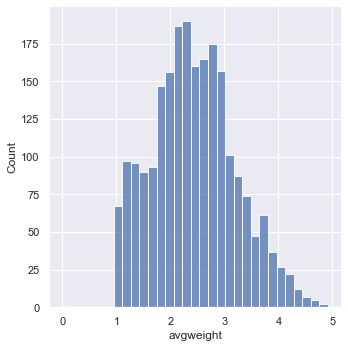

In [332]:
sns.displot(train_df['avgweight'])
plt.show()

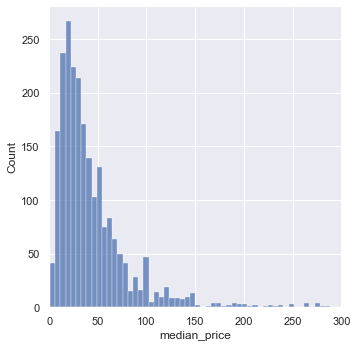

In [333]:
sns.displot(train_df['median_price'])
plt.xlim((0,300))
plt.show()

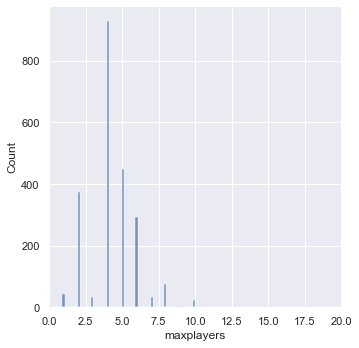

In [334]:
sns.displot(train_df['maxplayers'])
plt.xlim((0,20))
plt.show()

#### Checking CV scores with differernt xcols

In [335]:
#logplays objective
lr_cv(train_df, x_cols,    'log_plays', LinearRegression(), show_results=True,xcols_name='gp+t+c');
lr_cv(train_df, x_cols_np, 'log_plays', LinearRegression(), show_results=True,xcols_name='gpnp+t+c10');
lr_cv(train_df, x_cols_10, 'log_plays', LinearRegression(), show_results=True,xcols_name='gp+t+c10');
lr_cv(train_df, x_cols_20, 'log_plays', LinearRegression(), show_results=True,xcols_name='gp+t+c20');
lr_cv(train_df, x_cols_30, 'log_plays', LinearRegression(), show_results=True,xcols_name='gp+t+c30');


Objective: log_plays
Features:  gp+t+c
Mean train r2: 0.322
Mean test r2:  0.297

Objective: log_plays
Features:  gpnp+t+c10
Mean train r2: 0.322
Mean test r2:  0.297

Objective: log_plays
Features:  gp+t+c10
Mean train r2: 0.309
Mean test r2:  0.290

Objective: log_plays
Features:  gp+t+c20
Mean train r2: 0.316
Mean test r2:  0.290

Objective: log_plays
Features:  gp+t+c30
Mean train r2: 0.330
Mean test r2:  0.297



Not a huge variation between the results, so will go with the game properties + types + selected categories for logplays objective

In [345]:
lr_cv(train_df, x_cols,    'avg_rating', LinearRegression(), show_results=True,xcols_name='gp+t+c');
lr_cv(train_df, x_cols_np, 'avg_rating', LinearRegression(), show_results=True,xcols_name='gpnp+t+c10');
lr_cv(train_df, x_cols_10, 'avg_rating', LinearRegression(), show_results=True,xcols_name='gp+t+c10');
lr_cv(train_df, x_cols_20, 'avg_rating', LinearRegression(), show_results=True,xcols_name='gp+t+c20');
lr_cv(train_df, x_cols_30, 'avg_rating', LinearRegression(), show_results=True,xcols_name='gp+t+c30');

Objective: avg_rating
Features:  gp+t+c
Mean train r2: 0.476
Mean test r2:  0.462

Objective: avg_rating
Features:  gpnp+t+c10
Mean train r2: 0.476
Mean test r2:  0.462

Objective: avg_rating
Features:  gp+t+c10
Mean train r2: 0.467
Mean test r2:  0.456

Objective: avg_rating
Features:  gp+t+c20
Mean train r2: 0.476
Mean test r2:  0.461

Objective: avg_rating
Features:  gp+t+c30
Mean train r2: 0.481
Mean test r2:  0.458



Same story here, will use same feature sets for the two objectives.

### Polynomial transformation

In [567]:
lr_cv(train_df, x_cols, 'avg_rating', LinearRegression(), transformer = PolynomialFeatures(interaction_only=False),
      scale=True,show_results=True,xcols_name='gp+t+c');

lr_cv(train_df, x_cols, 'log_plays', LinearRegression(), transformer = PolynomialFeatures(interaction_only=False),
      scale=True,show_results=True,xcols_name='gp+t+c');

Objective: avg_rating
Features:  gp+t+c
Mean train r2: 0.660
Mean test r2:  -17822999044517024235520.000

Objective: log_plays
Features:  gp+t+c
Mean train r2: 0.509
Mean test r2:  -18091928324994695692288.000



Looks like we maybe need some regularization. Looks like it does help on the test data though! For now leaving interaction_only=False. Can take it out later to see if it helps

### Polynomial transformation +  LASSO and Ridge regularization

#### Lasso

In [569]:
lr_cv(train_df, x_cols, 'log_plays', Lasso(alpha=.1), transformer = PolynomialFeatures(include_bias = False,interaction_only=False),
      scale=True,show_results=True,xcols_name='gp+t+c');

lr_cv(train_df, x_cols, 'avg_rating', Lasso(alpha=.01), transformer = PolynomialFeatures(include_bias = False,interaction_only=False),
      scale=True,show_results=True,xcols_name='gp+t+c');



Objective: log_plays
Features:  gp+t+c
Mean train r2: 0.257
Mean test r2:  0.234

Objective: avg_rating
Features:  gp+t+c
Mean train r2: 0.543
Mean test r2:  0.499



A bit of improvement, will sweep through to find best alpha value

#### Ridge

In [573]:
lr_cv(train_df, x_cols, 'log_plays', RidgeCV(), transformer = PolynomialFeatures(include_bias = False,interaction_only=False),
      scale=True,show_results=True,xcols_name='gp+t+c');

lr_cv(train_df, x_cols, 'avg_rating', RidgeCV(), transformer = PolynomialFeatures(include_bias = False,interaction_only=False),
      scale=True,show_results=True,xcols_name='gp+t+c');



Objective: log_plays
Features:  gp+t+c
Mean train r2: 0.498
Mean test r2:  0.055

Objective: avg_rating
Features:  gp+t+c
Mean train r2: 0.654
Mean test r2:  0.346



Played around with some values, Ridge helps but not as much as Lasso. Will go ahead with Lasso because it also has the benefit of increased interprebility

#### Lasso alpha optimization

In [574]:
lp_test_r2s = []
ar_test_r2s = []
alphas = [.003,.005, .01,.025, .05, .1, .5, 1]
for alpha in alphas:
    lp_results = lr_cv(train_df, x_cols, 'log_plays', Lasso(alpha=alpha), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=False)
    ar_results = lr_cv(train_df, x_cols, 'avg_rating', Lasso(alpha=alpha), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=False)
    
    lp_test_r2s.append(np.mean(lp_results['test_r2']))
    ar_test_r2s.append(np.mean(ar_results['test_r2']))

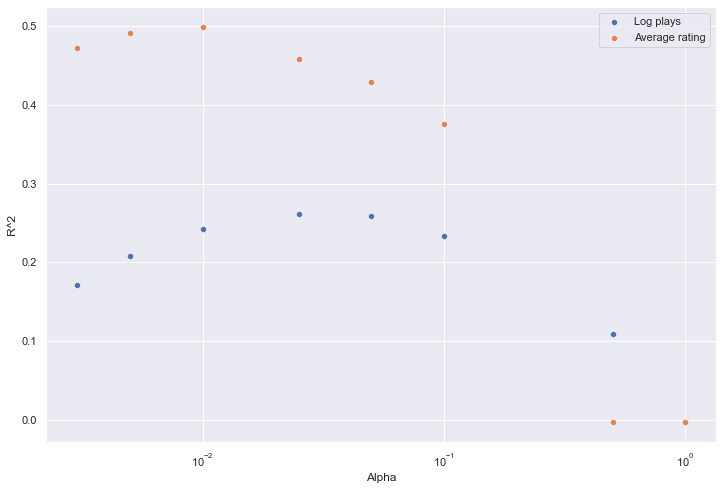

In [575]:
plt.figure(figsize = (12,8))
sns.scatterplot(x= alphas, y=lp_test_r2s, label = 'Log plays')
sns.scatterplot(x= alphas, y=ar_test_r2s, label = 'Average rating')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('R^2')
plt.show()

In [580]:
lp_results = lr_cv(train_df, x_cols, 'log_plays', Lasso(alpha=.025), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=True)
lp_results = lr_cv(train_df, x_cols, 'avg_rating', Lasso(alpha=.01), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=True)

Objective: log_plays
Features:  
Mean train r2: 0.367
Mean test r2:  0.261

Objective: avg_rating
Features:  
Mean train r2: 0.543
Mean test r2:  0.499



***Best alpha values are .01 for average rating and .025 for log plays, but will just use LassoCV going forward because I just realized its a thing***

### Just Regularization

In [609]:
lr_cv(train_df, x_cols, 'log_plays', LassoCV(),
      scale=True,show_results=True,xcols_name='gp+t+c');

lr_cv(train_df, x_cols, 'avg_rating', LassoCV(), 
      scale=True,show_results=True,xcols_name='gp+t+c');

Objective: log_plays
Features:  gp+t+c
Mean train r2: 0.269
Mean test r2:  0.240

Objective: avg_rating
Features:  gp+t+c
Mean train r2: 0.470
Mean test r2:  0.450



In [610]:
lr_cv(train_df, x_cols, 'log_plays', RidgeCV(),
      scale=True,show_results=True,xcols_name='gp+t+c');

lr_cv(train_df, x_cols, 'avg_rating', RidgeCV(), 
      scale=True,show_results=True,xcols_name='gp+t+c');

Objective: log_plays
Features:  gp+t+c
Mean train r2: 0.271
Mean test r2:  0.239

Objective: avg_rating
Features:  gp+t+c
Mean train r2: 0.472
Mean test r2:  0.450



**Just retularization doesnt really help as much as polynomial features + regularization**

## Looking at residuals and pair plots

R^2: 0.284
MAE: 1.126


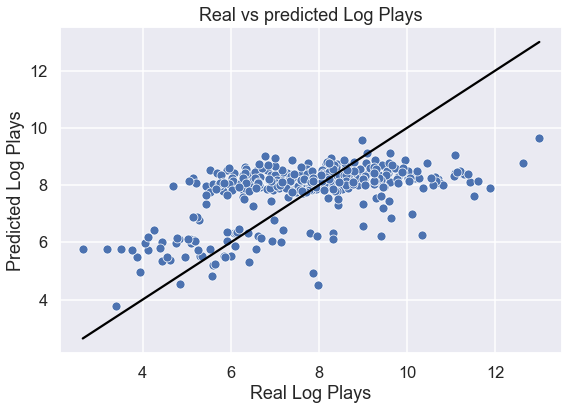

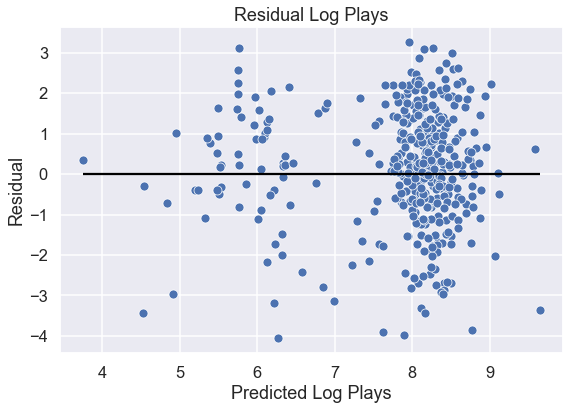

In [759]:
fit_plot_train(train_df, x_cols, 'log_plays', 'Log Plays', LassoCV(alphas = alphas, max_iter= 10000),
               transformer=PolynomialFeatures(include_bias = False,interaction_only=False),
               scale=True, show_graphs = True)


Some weird bimodality going on here, not sure why it predicts so many things will be around 8 log_plays

R^2: 0.508
MAE: 0.327


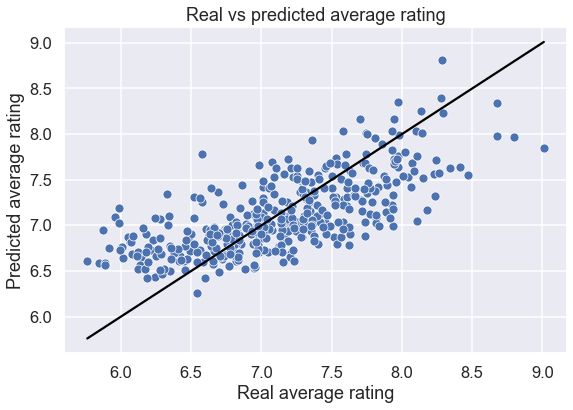

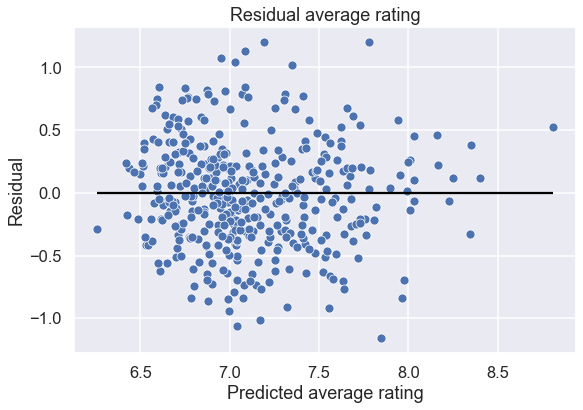

In [760]:
fit_plot_train(train_df, x_cols, 'avg_rating', 'average rating', LassoCV(alphas=alphas),
               transformer=PolynomialFeatures(include_bias = False,interaction_only=False),
               scale=True, show_graphs = True)

Average rating real vs predicted and residual graphs look better. Top at least looks likes its centered around a line, except for low real values (easier to predict when game is good?), and bottom doesnt have too much variance between predicted values.

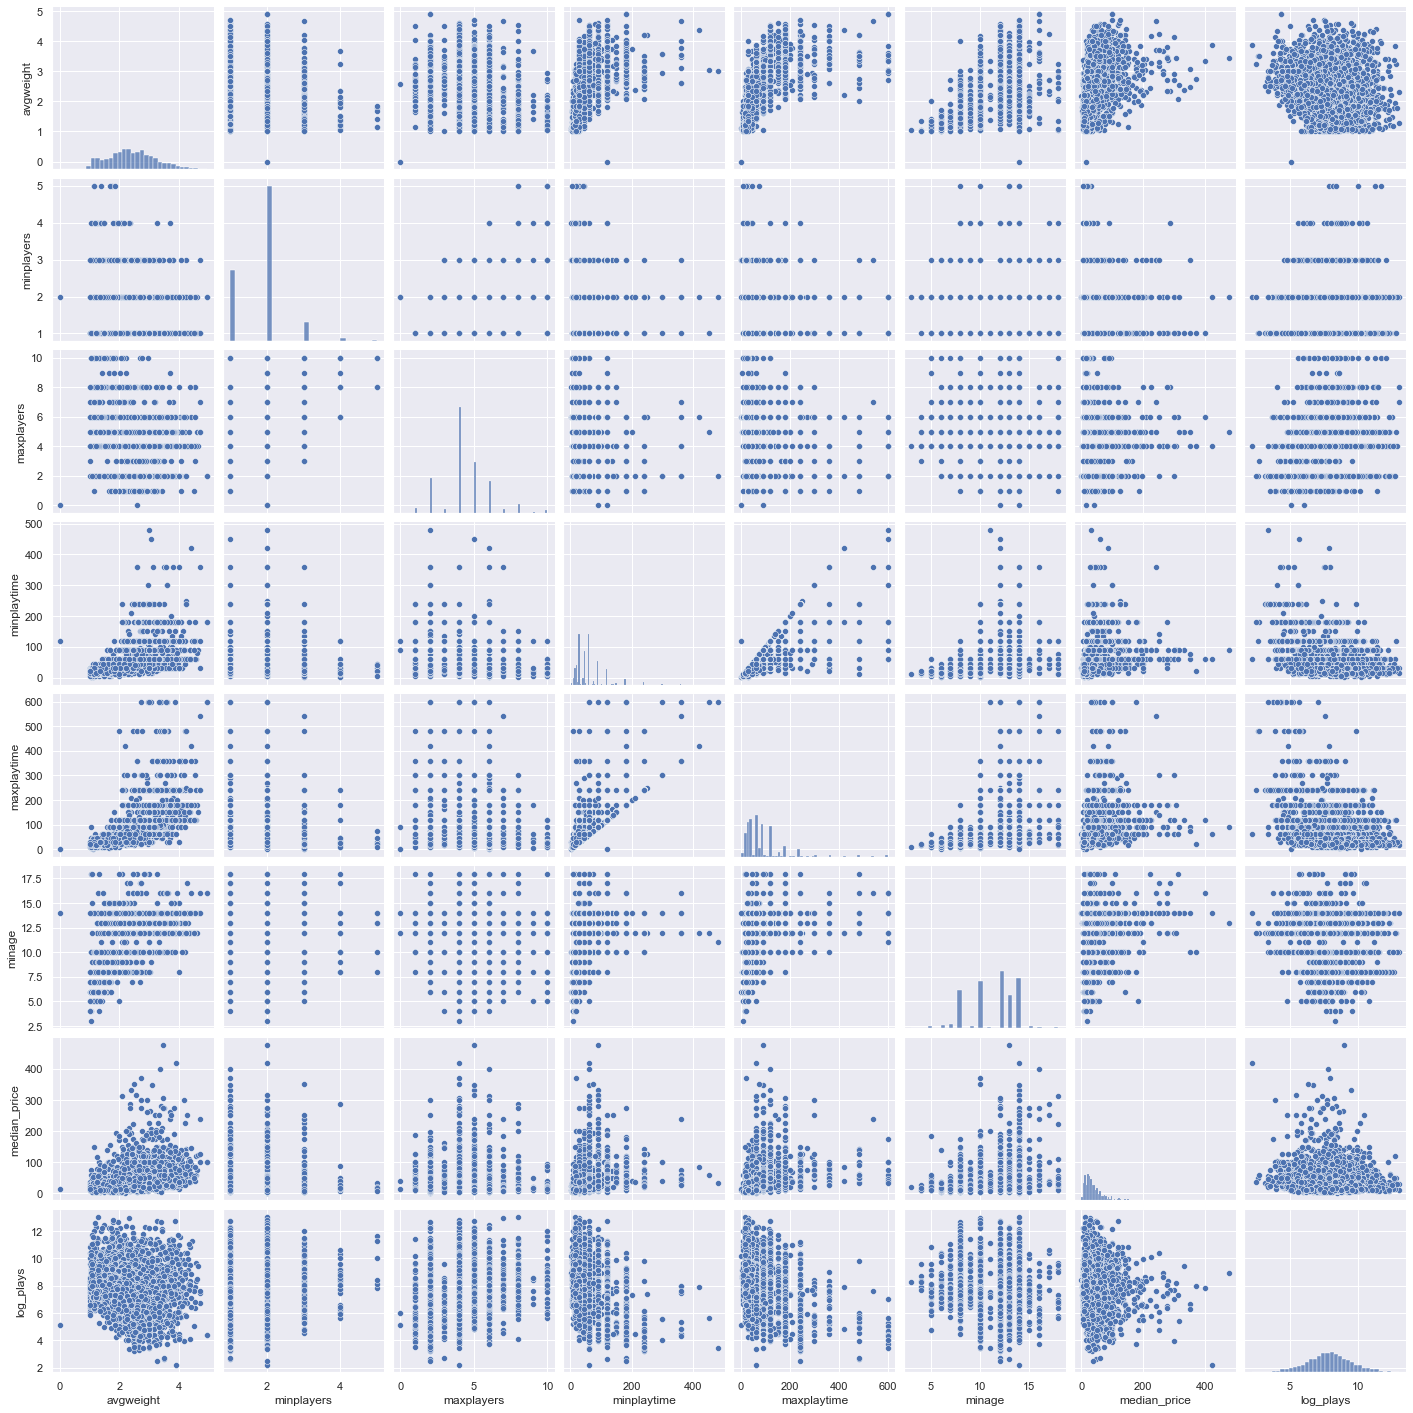

In [586]:
sns.pairplot(df[game_properties + ['log_plays']])

**Hard to see any functional dependence of log_plays on anything

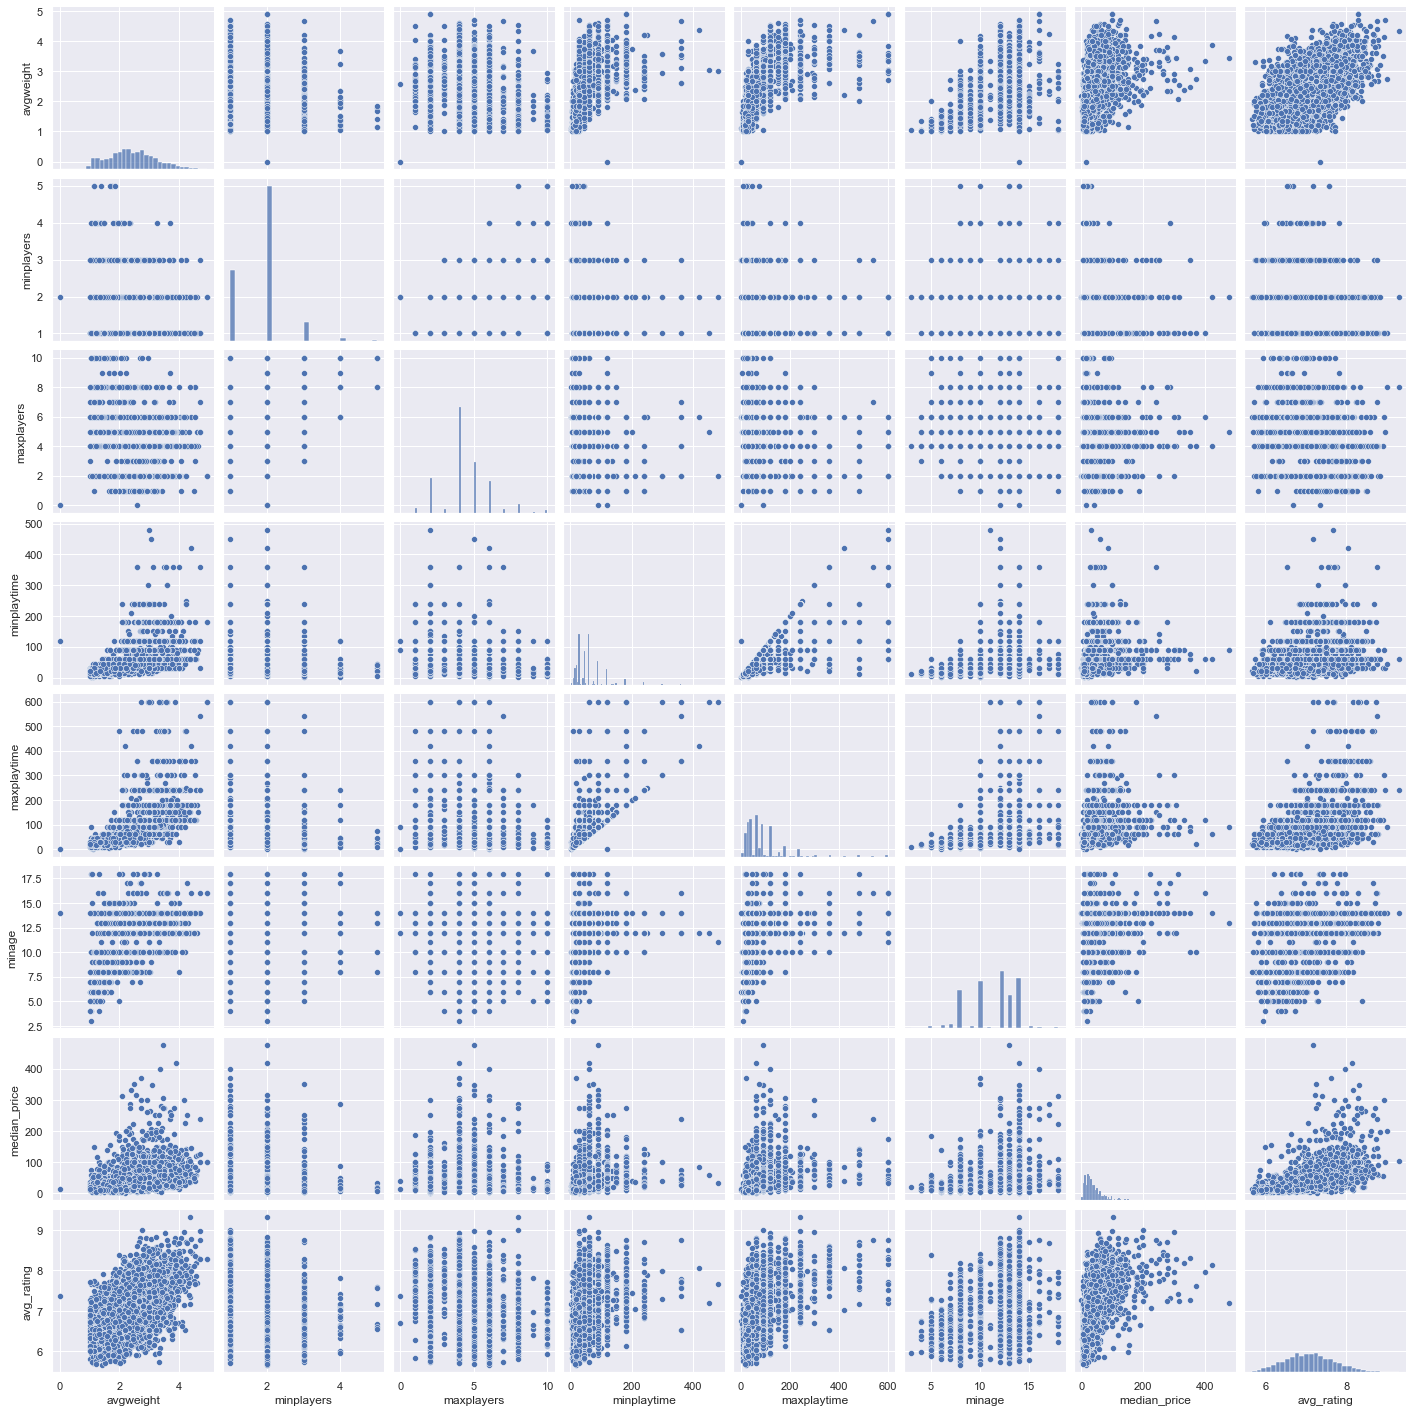

In [587]:
sns.pairplot(df[game_properties + ['avg_rating']])

**Looks like minplaytime and maxplaytime and median_price might  have square root or log dependence for avg_rating**

## Changing around features and misc adjustments

### Interaction_only testing

In [743]:
lr_cv(train_df, x_cols, 'avg_rating', LassoCV(alphas=alphas, max_iter=10000), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=True),scale=True,
                       show_results=True)
lr_cv(train_df, x_cols, 'avg_rating', LassoCV(alphas=alphas, max_iter=10000), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=True);

lr_cv(train_df, x_cols, 'log_plays', LassoCV(alphas=alphas, max_iter=10000), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=True),scale=True,
                       show_results=True)
lr_cv(train_df, x_cols, 'log_plays', LassoCV(alphas=alphas, max_iter=10000), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=True);

Objective: avg_rating
Features:  
Mean train r2: 0.507
Mean test r2:  0.448

Objective: avg_rating
Features:  
Mean train r2: 0.527
Mean test r2:  0.480

Objective: log_plays
Features:  
Mean train r2: 0.326
Mean test r2:  0.248

Objective: log_plays
Features:  
Mean train r2: 0.358
Mean test r2:  0.261



Having interaction_only = False seems slightly better

### Squre root of numerical colums

In [725]:
lr_cv(train_df, x_cols, 'avg_rating', Lasso(alpha=.01), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=True)
lr_cv(train_df, x_cols_sqrt, 'avg_rating', Lasso(alpha=.01), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=True);

Objective: avg_rating
Features:  
Mean train r2: 0.542
Mean test r2:  0.488

Objective: avg_rating
Features:  
Mean train r2: 0.542
Mean test r2:  0.488



In [724]:
lp_results = lr_cv(train_df, x_cols, 'log_plays', LassoCV(alphas=alphas, max_iter=10000), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=True)
lp_results = lr_cv(train_df, x_cols_sqrt, 'log_plays', LassoCV(alphas=alphas, max_iter=10000), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=True)

Objective: log_plays
Features:  
Mean train r2: 0.369
Mean test r2:  0.276

Objective: log_plays
Features:  
Mean train r2: 0.369
Mean test r2:  0.276



Taking the square root of some of the columns doesnt really do anything - just going to call it for avg_rating, going to try a bit more for log_plays

### Using fewer columns

In [761]:
price_only = ['median_price']+type_cols+selected_categories
weight_only = ['avgweight']+type_cols+selected_categories
reduced = ['avgweight', 'minplayers','minplaytime',  'minage', 'median_price']+type_cols+selected_categories
lp_results = lr_cv(train_df, reduced, 'log_plays', LinearRegression(), show_results=True)
lp_results = lr_cv(train_df, reduced, 'log_plays', LassoCV(alphas=alphas, max_iter=10000), 
                       transformer = PolynomialFeatures(include_bias = False,interaction_only=False),scale=True,
                       show_results=True)

Objective: log_plays
Features:  
Mean train r2: 0.274
Mean test r2:  0.234

Objective: log_plays
Features:  
Mean train r2: 0.336
Mean test r2:  0.251



cycled through these, not really any improvement

## Final modeling/viz

In [925]:
lcv=LassoCV(alphas=alphas, max_iter=10000)
s = StandardScaler()
pf = PolynomialFeatures(include_bias = False, interaction_only = False)
X_train = train_df[x_cols].copy()
X_test = test_df[x_cols].copy()
y_train = train_df['avg_rating'].copy()
y_test  =  test_df['avg_rating'].copy()

pf.fit(X_train)
X_train=pf.transform(X_train)
X_test=pf.transform(X_test)

s.fit(X_train)
X_train=s.fit_transform(X_train)
X_test=s.transform(X_test)

lcv.fit(X_train, y_train)
print(lcv.score(X_train, y_train))
print(lcv.score(X_test, y_test))
print(lcv.alpha_)

0.5191296612181358
0.49101978542073965
0.01


In [926]:
lcv=LassoCV(alphas=alphas, max_iter=10000)
s = StandardScaler()
pf = PolynomialFeatures(include_bias = False, interaction_only = False)
X_train = train_df[x_cols].copy()
X_test = test_df[x_cols].copy()
y_train = train_df['log_plays'].copy()
y_test  =  test_df['log_plays'].copy()

pf.fit(X_train)
X_train=pf.transform(X_train)
X_test=pf.transform(X_test)

s.fit(X_train)
X_train=s.fit_transform(X_train)
X_test=s.transform(X_test)

lcv.fit(X_train, y_train)
print(lcv.score(X_train, y_train))
print(lcv.score(X_test, y_test))
print(lcv.alpha_)

0.35694871213457824
0.22336226258770864
0.025


In [927]:
X_train = train_df[x_cols].copy()
X_test = test_df[x_cols].copy()
y_train_ar = train_df['avg_rating'].copy()
y_test_ar  =  test_df['avg_rating'].copy()


rating_model = make_pipeline(PolynomialFeatures(include_bias=False,interaction_only=False), StandardScaler(),
                                 LassoCV(alphas=alphas,max_iter=10000))


rating_model.fit(X_train, y_train_ar)
print('Training R2',rating_model.score(X_train, y_train_ar))
print('Test R2',rating_model.score(X_test,  y_test_ar))
print('Test MAE', mean_absolute_error(y_test_ar,rating_model.predict(X_test)))

Training R2 0.5191296612181358
Test R2 0.49101978542073965
Test MAE 0.3430360518831899


In [928]:
X_train = train_df[x_cols].copy()
X_test = test_df[x_cols].copy()
y_train_lp = train_df['log_plays'].copy()
y_test_lp  =  test_df['log_plays'].copy()


logplays_model = make_pipeline(PolynomialFeatures(include_bias=False,interaction_only=False), StandardScaler(),
                                 LassoCV(alphas=alphas,max_iter=10000))

logplays_model.fit(X_train, y_train_lp)
print('Training R2',logplays_model.score(X_train, y_train_lp))
print('Test R2',logplays_model.score(X_test,  y_test_lp))
print('Test MAE',mean_absolute_error(y_test_lp, logplays_model.predict(X_test)))

Training R2 0.35694871213457824
Test R2 0.22336226258770864
Test MAE 1.1222561508291233


In [929]:
def coef_df(model):
    features = model.steps[0][-1].get_feature_names(x_cols)
    coefs = model.steps[-1][-1].coef_
    df = pd.DataFrame(list(zip(features,coefs)),columns =['feature', 'coef'])
    df['sign'] = df['coef'].apply(lambda c: 'Positive' if c>0 else 'Negative')
    df['abs_coef'] = np.abs(df['coef'])
    df.sort_values('abs_coef', ascending=False, inplace=True)
    return df

In [933]:
coef_df(rating_model).head(20)

,feature,coef,sign,abs_coef
6,median_price,0.295389,Positive,0.295389
0,avgweight,0.156904,Positive,0.156904
188,median_price^2,-0.122961,Negative,0.122961
41,avgweight Wargame,0.082643,Positive,0.082643
33,avgweight maxplaytime,0.057984,Positive,0.057984
60,minplayers minplaytime,-0.039770,Negative,0.039770
34,avgweight minage,0.031524,Positive,0.031524
1,minplayers,-0.029589,Negative,0.029589
448,Miniatures Fighting,0.028280,Positive,0.028280
67,minplayers thematic,-0.025274,Negative,0.025274


In [934]:
coef_df(logplays_model).head(20)

,feature,coef,sign,abs_coef
12,Wargame,-0.642933,Negative,0.642933
191,median_price strategy,0.206465,Positive,0.206465
8,family,0.145688,Positive,0.145688
257,strategy Wargame,0.124414,Positive,0.124414
276,thematic Wargame,0.113779,Positive,0.113779
201,median_price Economic,0.102295,Positive,0.102295
188,median_price^2,-0.100720,Negative,0.100720
60,minplayers minplaytime,-0.083304,Negative,0.083304
364,Card Game Civilization,0.081123,Positive,0.081123
3,minplaytime,-0.080782,Negative,0.080782


In [931]:
rating_classifier.steps[0][-1].get_feature_names(x_cols)

['avgweight',
 'minplayers',
 'maxplayers',
 'minplaytime',
 'maxplaytime',
 'minage',
 'median_price',
 'customizable',
 'family',
 'strategy',
 'thematic',
 'Print & Play',
 'Wargame',
 'Abstract Strategy',
 'Science Fiction',
 'Card Game',
 'Fantasy',
 'Deduction',
 'Horror',
 'Economic',
 'Civilization',
 'Adventure',
 'Party Game',
 'Miniatures',
 'City Building',
 'Exploration',
 'Bluffing',
 'Animals',
 'Fighting',
 'avgweight^2',
 'avgweight minplayers',
 'avgweight maxplayers',
 'avgweight minplaytime',
 'avgweight maxplaytime',
 'avgweight minage',
 'avgweight median_price',
 'avgweight customizable',
 'avgweight family',
 'avgweight strategy',
 'avgweight thematic',
 'avgweight Print & Play',
 'avgweight Wargame',
 'avgweight Abstract Strategy',
 'avgweight Science Fiction',
 'avgweight Card Game',
 'avgweight Fantasy',
 'avgweight Deduction',
 'avgweight Horror',
 'avgweight Economic',
 'avgweight Civilization',
 'avgweight Adventure',
 'avgweight Party Game',
 'avgweight M

## For fun - randomly generating games

In [796]:
def make_random_game():
    from random import uniform, randrange,randint
    game = []
    game.append(round(uniform(1,5),2)) #weight
    game.append(randint(1,10))
    game.append(randint(game[1],10))
    game.append(randrange(10,120,10))
    game.append(randrange(game[3],480,10))
    game.append(randint(1,21))
    game.append(randint(10,500))
    categories = np.random.randint(2, size = 22)
    game+= list(categories)
    return game

def rgame_info(game):
    print('Name:')
    for num,category in zip(game[:7],x_cols[:7]):
        print(category,':',num)
    print('Categories:')
    for num,category in zip(game[7:],x_cols[7:]):
        
        if num ==1: print(category)
          

In [797]:
a=make_random_game()
rgame_info(a)

Name:
avgweight : 1.73
minplayers : 4
maxplayers : 10
minplaytime : 10
maxplaytime : 180
minage : 9
median_price : 62
Categories:
customizable
family
strategy
Wargame
Abstract Strategy
Science Fiction
Fantasy
Civilization
Miniatures
City Building
Exploration
Bluffing


In [784]:
len(a[7:])

TypeError: 'NoneType' object is not subscriptable

In [946]:
a = make_random_game()
rgame_info(a)
rating_model.predict([a])

Name:
avgweight : 3.75
minplayers : 6
maxplayers : 8
minplaytime : 50
maxplaytime : 180
minage : 19
median_price : 117
Categories:
customizable
strategy
thematic
Wargame
Abstract Strategy
Horror
Economic
Party Game
Miniatures
Exploration
Bluffing
Animals


array([7.49088589])

In [942]:
rgame_info(a)


Name:
avgweight : 4.84
minplayers : 8
maxplayers : 8
minplaytime : 20
maxplaytime : 140
minage : 12
median_price : 261
Categories:
customizable
Print & Play
Wargame
Abstract Strategy
Card Game
Fantasy
Deduction
Civilization
Party Game
Miniatures
Bluffing
Name:
avgweight : 1.31
minplayers : 8
maxplayers : 10
minplaytime : 10
maxplaytime : 230
minage : 6
median_price : 296
Categories:
customizable
Wargame
Abstract Strategy
Science Fiction
Fantasy
Horror
Fighting
